In [1]:
!pip install pandas>=2.2.0
!pip install networkx>=3.0
!pip install bs4
!pip install lxml
!pip install transformers==4.46.0 sentence-transformers==2.2.2 huggingface-hub==0.15.1
!pip install pinecone-client
!pip install -U deepeval
!pip install chromadb==0.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install huggingface-hub==0.15.1 and transformers==4.46.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested huggingface-hub==0.15.1
    transformers 4.46.0 depends on huggingface-hub<1.0 and >=0.23.2

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
import numpy as np
import pinecone
from pinecone import Pinecone, ServerlessSpec
import os
from google.colab import userdata
import torch
from deepeval import evaluate
import google.generativeai as genai
from deepeval.dataset import EvaluationDataset
from deepeval.synthesizer.config import ContextConstructionConfig
from deepeval.synthesizer import Synthesizer
import json
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


#Reto de Qubika

Samuel Hernández Espitia

##Scraping

Para el proceso de scraping se tuvieron en cuenta principalmente dos paginas principales de noticias, la primera es El Espectador y la segunda es Semana, debido a que la estructura de las paginas de cada una de estas era distinta, fue necesario implementar un método diferente para cada uno de estos, con el fin de obtener los datos de las noticias.

Para esta tarea se utilizó la librearia de **BeautifulSoup**

In [3]:
def espectador_scrape(website):
  response = requests.get(website)

  if response.status_code == 200:
    try:
      content = response.text
      soup = BeautifulSoup(content, 'lxml')

      header_box = soup.find('div', class_='ArticleHeader')

      title = header_box.find('h1', class_='Title').get_text()

      author = header_box.find('div', class_='ArticleHeader-Author').get_text()

      header_info = soup.find('div', class_='ArticleHeader-ContainerInfo')
      datetime = header_info.find('div', class_='Datetime ArticleHeader-Date').get_text()

      date = datetime.split('-')[0].strip()

      content_box=soup.find('div', class_='Article-Content')
      content = content_box.find_all('p', class_='font--secondary')
      article_content = ""

      for p in content:
        article_content += p.get_text() + " "

      return {'title' : title, 'author' : author, 'date' : date, 'article_content' : article_content}
    except Exception as e:
      print('Error extrayendo el texto de la pagina: ', website)
      print(e)
      return None
  else:
    print('Error extrayendo el texto de la pagina: ', website)

In [4]:
def semana_scrape(website):
  response = requests.get(website)

  if response.status_code == 200:
    try:
      content = response.text

      soup = BeautifulSoup(content, 'lxml')

      header_box = soup.find('div', class_="mx-auto max-w-[968px]")

      title = header_box.find('h1').get_text()

      author = header_box.find('span', class_="mb-1 border-l border-primary pl-2 text-sm font-medium").get_text()

      date = header_box.find('div', class_="pl-2 text-xs leading-none").get_text()

      body = soup.find('div', class_="paywall mx-auto mb-4")

      content = body.find_all('p')

      article_content = ""

      for p in content:
        article_content += p.get_text() + " "

      return {'title' : title, 'author' : author, 'date' : date, 'article_content' : article_content}
    except Exception as e:
      print('Error extrayendo el texto de la pagina: ', website)
      print(e)
      return None
  else:
    print('Error extrayendo el texto de la pagina: ', website)

Despues de realizar los metodos de scraping correspondiente a cada pagina, se procedió a recolectar los enlaces de las noticias de cada pagina, para lo cual, se recolectaron 10 de cada uno, con un total de 20 enlaces de noticias.

In [5]:
espectador_websites = [
          'https://www.elespectador.com/ambiente/una-negociacion-acalorada-la-cop29-inicio-con-malas-noticias-sobre-la-temperatura-global/',
          'https://www.elespectador.com/ambiente/cop29-la-idea-con-la-colombia-quiere-ser-protagonista-en-la-cumbre-de-cambio-climatico/',
          'https://www.elespectador.com/colombia/mas-regiones/explosion-de-motocicleta-dejo-un-soldado-muerto-y-otro-herido-en-el-plateado/',
          'https://www.elespectador.com/colombia/cali/marcela-reyes-desmintio-muerte-de-exotic-dj-quien-fue-herido-en-balacera-en-motel-de-cali/',
          'https://www.elespectador.com/colombia/cali/marcela-reyes-desmintio-muerte-de-exotic-dj-quien-fue-herido-en-balacera-en-motel-de-cali/',
          'https://www.elespectador.com/economia/macroeconomia/confianza-del-consumidor-en-estados-unidos-aumento-en-octubre/',
          'https://www.elespectador.com/moda-e-industria/el-ano-arranco-mal-para-la-industria-manufacturera-con-una-caida-en-enero/',
          'https://www.elespectador.com/cromos/vida-sana/blue-monday-por-que-hoy-es-el-dia-mas-triste-del-ano/',
          'https://www.elespectador.com/economia/macroeconomia/las-exportaciones-tuvieron-un-crecimiento-en-abril-cual-fue-la-razon/',
          'https://www.elespectador.com/autos/motos-de-100cc-y-125cc-por-que-son-las-preferidas-por-los-colombianos-y-para-que-se-usan/'
          ]


In [6]:
semana_websites= [
          'https://www.semana.com/mejor-colombia/articulo/impresionante-las-cifras-que-le-dejo-a-cali-la-cop16/202409/',
          'https://www.semana.com/como/articulo/por-que-se-conmemora-el-dia-de-la-mujer-el-8-de-marzo/202449/',
          'https://www.semana.com/confidenciales/articulo/la-principal-preocupacion-de-petro-es-ir-a-juicio-politico-pierre-onzaga/202443/',
          'https://www.semana.com/nacion/articulo/corte-suprema-cerro-proceso-a-la-excongresista-aida-merlano-por-financiar-campana-a-la-camara-de-mauricio-salazar/202430/',
          'https://www.semana.com/semana-tv/vicky-en-semana/articulo/estos-son-los-retos-que-tendra-el-presidente-petro-en-los-dos-anos-que-le-restan-de-gobierno/202405/',
          'https://www.semana.com/economia/articulo/asi-quedaron-los-precios-de-la-gasolina-y-el-diesel-en-las-principales-ciudades-de-colombia/202456/',
          'https://www.semana.com/mundo/articulo/el-peligroso-lider-del-cartel-de-sinaloa-ismael-el-mayo-zambada-se-declara-inocente-en-un-tribunal-en-nueva-york/202412/',
          'https://www.semana.com/economia/macroeconomia/articulo/economia-colombiana-tuvo-un-ligero-crecimiento-en-febrero-tan-solo-del-13-segun-el-ise-del-dane/202413/',
          'https://www.semana.com/nacion/articulo/procuradora-exige-al-general-salamanca-proteger-a-funcionarios-judiciales-cuando-la-protesta-se-sale-de-control-hay-que-actuar-inmediatamente/202411/',
          'https://www.semana.com/economia/finanzas-personales/articulo/pago-de-prima-en-colombia-ia-revela-los-cinco-errores-mas-comunes-al-gastar-esa-plata-en-junio/202401/'
          ]

Con toda la información correctamente recopilada se construyó un dataframe en el cual se almacenaron las noticias de ambas fuentes como se observa a continuacion:

In [7]:
df = pd.DataFrame()

for website in espectador_websites:
  df = df._append(espectador_scrape(website), ignore_index=True)

for website in semana_websites:
  df = df._append(semana_scrape(website), ignore_index=True)

df

,title,author,date,article_content
0,Una negociación acalorada: COP29 inició con ma...,Andrés Mauricio Díaz Páez y - Enviado especial...,11 de noviembre de 2024,La Conferencia de las Naciones Unidas sobre Ca...
1,La idea con la que Colombia quiere ser protago...,Andrés Mauricio Díaz Páez y Enviado especial a...,13 de noviembre de 2024,"En 1987, Bolivia firmó el primer acuerdo en la..."
2,Explosión de motocicleta dejó un soldado muert...,Redacción Colombia,08 de noviembre de 2024,"En la mañana de este viernes 8 de noviembre, s..."
3,"Marcela Reyes desmintió muerte de Exotic Dj, q...",Redacción Colombia,07 de noviembre de 2024,Marcela Reyes expareja sentimental de Daniel A...
4,"Marcela Reyes desmintió muerte de Exotic Dj, q...",Redacción Colombia,07 de noviembre de 2024,Marcela Reyes expareja sentimental de Daniel A...
5,Confianza del consumidor en Estados Unidos aum...,Agencia AFP y Agencia Bloomberg,29 de octubre de 2024,La confianza de los consumidores en la economí...
6,El año arrancó mal para la industria manufactu...,Redacción Economía,15 de marzo de 2024,En enero la producción real de la industria ma...
7,Blue Monday: ¿Por qué hoy es el “día más trist...,Por Redacción Cromos,15 de enero de 2024,"La palabra en inglés “Blue”, además de traduci..."
8,Las exportaciones tuvieron un crecimiento en a...,Redacción Economía,04 de junio de 2024,En abril de 2024 las ventas externas del país ...
9,Motos de 100cc y 125cc: ¿Por qué son las prefe...,Redacción Autos,17 de mayo de 2024,Las motos de 100cc y 125cc se han consolidado ...


Se limpia el contenido de las noticias, para eliminar posibles caracteres y espacios innecesarios.

In [8]:
def clean_text(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = text.strip()
  text = re.sub(r'\s+', ' ', text)
  return text

df['title'] = df['title'].apply(clean_text)
df['article_content'] = df['article_content'].apply(clean_text)

df = df.drop_duplicates()

df

,title,author,date,article_content
0,Una negociación acalorada COP29 inició con mal...,Andrés Mauricio Díaz Páez y - Enviado especial...,11 de noviembre de 2024,La Conferencia de las Naciones Unidas sobre Ca...
1,La idea con la que Colombia quiere ser protago...,Andrés Mauricio Díaz Páez y Enviado especial a...,13 de noviembre de 2024,En 1987 Bolivia firmó el primer acuerdo en la ...
2,Explosión de motocicleta dejó un soldado muert...,Redacción Colombia,08 de noviembre de 2024,En la mañana de este viernes 8 de noviembre se...
3,Marcela Reyes desmintió muerte de Exotic Dj qu...,Redacción Colombia,07 de noviembre de 2024,Marcela Reyes expareja sentimental de Daniel A...
5,Confianza del consumidor en Estados Unidos aum...,Agencia AFP y Agencia Bloomberg,29 de octubre de 2024,La confianza de los consumidores en la economí...
6,El año arrancó mal para la industria manufactu...,Redacción Economía,15 de marzo de 2024,En enero la producción real de la industria ma...
7,Blue Monday Por qué hoy es el día más triste d...,Por Redacción Cromos,15 de enero de 2024,La palabra en inglés Blue además de traducir a...
8,Las exportaciones tuvieron un crecimiento en a...,Redacción Economía,04 de junio de 2024,En abril de 2024 las ventas externas del país ...
9,Motos de 100cc y 125cc Por qué son las preferi...,Redacción Autos,17 de mayo de 2024,Las motos de 100cc y 125cc se han consolidado ...
10,Impresionante las cifras que le dejó a Cali la...,Redacción Semana,14 de noviembre de 2024,La COP16 cerró con resultados excepcionales pa...


Despues se almacena la información ya procesada para que no sea necesario ejecutar constantemente todo el proceso anterior.

In [9]:
df.to_csv('articles.csv', index=True)

In [ ]:
article_contents = df['article_content'].tolist()

article = article_contents[0] + article_contents[1]

with open('articles.txt', 'w') as file:
    file.write(article)

##Base de Datos Vectorial

###Carga del modelo

El modelo **all-MiniLM-L6-v2** es una versión ligera de Sentence-BERT, que está diseñado para generar embeddings (representaciones vectoriales) de frases o párrafos. Este representa el primer paso a la creación de la base de datos vectorial.

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

embeddings = model.encode(article_contents)
dimension = embeddings.shape[1]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

A continuacon se observa la representación grafica de la correlación entre los diferentes vectores que representan cada una de las noticias. Se puede observar que la correlacion entre estos es muy baja ya que son muy pocos los que se encuentran cercanos a 1

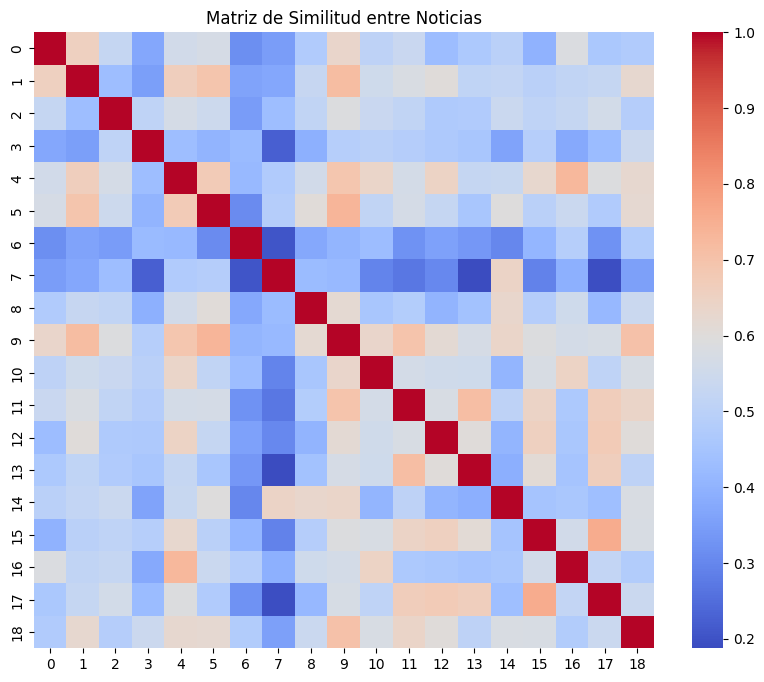

In [ ]:
similarity_matrix = np.dot(embeddings, embeddings.T)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Similitud entre Noticias')
plt.show()

###Inicializar cliente de Pinecone


Despues de haber convertido las noticias en embedings es necesario hacer uso de una base de datos vectorial de la cual se pueda consultar facilmente estos vectores y sus similitudes. Por lo tanto, se hace uso de Pinecone, que es una base de datos vectorial administrada y diseñada específicamente para la búsqueda y recuperación eficiente de incrustaciones de vectores.

A continuación se crea un nuevo indice en la base de datos y se insertan los embedings con el indice correspondiente al del dataframe.

In [ ]:
key = userdata.get('PINECONE_KEY')
pc = Pinecone(api_key=key)



if 'news' not in pc.list_indexes().names():
    pc.create_index(
        name='news',
        dimension=dimension,
        metric='cosine',
        spec=ServerlessSpec(
          cloud="aws",
          region="us-east-1"
        )
    )

index_info = pc.describe_index("news")
host = index_info['host']

index = pc.Index("news", host=host)

for i, embedding in enumerate(embeddings):
    index.upsert([(str(i), embedding)])

###Consulta por similitud

Cuando ya se ha configurado correctamente la base de datos de Pinecone, es posible realizar consultar por similitud, en la que una query es codificada y comparada con los vectores almacenados para encontrar los "top_k" más similares.

In [ ]:
def get_context(query_text, top_k):
    query_embedding = model.encode([query_text])[0]

    query_embedding = query_embedding.tolist()

    resultado = index.query(vector=query_embedding, top_k=top_k, include_values=True)

    resultados_ids = [match['id'] for match in resultado['matches']]
    distancias = [match['score'] for match in resultado['matches']]

    similar_news = df.iloc[[int(id) for id in resultados_ids]]

    content = similar_news['article_content']

    context = " ".join(content)

    return context

##Incorporación de RAG

###Carga del modelo

Teniendo ya la base de datos vectorial, para completar el flujo de trabajo para RAG, es necesario la integracion de un modelo de lenguaje, en este caso se hace uso de una API del modelo generativo de Google, Gemini, especificamente la version 1.5-flash, que cuenta con excelentes capacidades para procesar tareas de resumen y de preguntas y respuestas.

In [ ]:
genai.configure(api_key=userdata.get('GEMINI_API'))

gem_model = genai.GenerativeModel('gemini-1.5-flash')

In [ ]:
def generate_reponse(query_text, context):
    try:
      prompt = f"Limitate a responder brevemente la siguiente pregunta:{query_text}\nDe acuerdo a el siguiente contexto:\n{context}"
      response = gem_model.generate_content(prompt)
      return response.text
    except Exception as e:
      return f"Ocurrió un error inesperado: {e}"

In [ ]:
def response(query_text):
    context = get_context(query_text, 1)
    print(context)
    response = generate_reponse(
        query_text,
        context
        )

    return response

##Consulta

In [ ]:
consulta = "Cuales fueron los acontecimientos más importantes de la COP?"
respuesta = response(consulta)
print("Pregunta:", consulta)
print("Respuesta:", respuesta)

ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1828.09ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 812.12ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 507.14ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 483.41ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 484.16ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 508.01ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 5186.47ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:gener

Pregunta: Cuales fueron los acontecimientos más importantes de la COP?
Respuesta: Por favor, proporcione el contexto. Necesito el texto sobre la COP para poder responder su pregunta.



##Evaluación de metricas

###Generación de datasets de pruebas

Para evaluar correctamente el rendimiento del modelo planteado, se va a hacer uso de la librearia de DeepEval, que brinda herramientas para la creación de casos de pruebas, y para la evaluación de los mismos.

A continuacion se hizo uso de una herramienta de DeepEval que permite la creación de Goldens, que son casos de pruebas que aún no tienen la respuesta de nuestro modelo. Es decir, estos contienen el contextos y preguntas relacionadas a este contexto, pero por supuesto sin aun la respuesta del modelo que es la que se desea evaluar.

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
dataset = EvaluationDataset()

file_path = "goldens_dataset.json"

if os.path.exists(file_path):
    dataset.add_goldens_from_json_file(
      file_path="goldens_dataset.json",
      input_key_name="query"
    )
else:
  context_construction_config = ContextConstructionConfig(
      max_contexts_per_document=10,
      chunk_size=560
  )
  synthesizer = Synthesizer(model="gpt-3.5-turbo")
  dataset.generate_goldens_from_docs(
      synthesizer=synthesizer,
      document_paths=["articles.txt"],
      max_goldens_per_context=2,
      context_construction_config=context_construction_config
  )

Event loop is already running. Applying nest_asyncio patch to allow async execution...


✨ 🧩 ✨ Generating Contexts: 100%|██████████| 30/30 [00:09<00:00,  3.06it/s]


Utilizing 10 out of 11 chunks.

✨ Generating up to 20 goldens using DeepEval (using gpt-3.5-turbo and text-embedding-3-small, method=docs): 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Para evitar generar constantemente los Goldens se decidió almacenarlos en formato Json, para cuando sea necesario ejecutar nuevamente las pruebas estos puedan ser reutilizados

In [ ]:
def save_goldens_as_json(dataset, file_path):
    """
    Guarda los goldens de un EvaluationDataset en un archivo JSON.

    Args:
        dataset (EvaluationDataset): El dataset que contiene los goldens.
        file_path (str): Ruta donde se guardará el archivo JSON.
    """
    goldens_data = []
    for golden in dataset.goldens:
        golden_dict = {
            "input": golden.input,
            "expected_output": golden.expected_output,
            "actual_output": golden.actual_output,
            "context": golden.context,
            "retrieval_context": golden.retrieval_context,
            "additional_metadata": golden.additional_metadata,
            "comments": golden.comments,
            "tools_called": golden.tools_called,
            "expected_tools": golden.expected_tools,
            "source_file": golden.source_file,
        }
        goldens_data.append(golden_dict)

    with open(file_path, "w", encoding="utf-8") as json_file:
        json.dump(goldens_data, json_file, ensure_ascii=False, indent=4)

    print(f"Goldens guardados exitosamente en {file_path}")

In [ ]:
if not os.path.exists(file_path):
  save_goldens_as_json(dataset, file_path)

Goldens guardados exitosamente en goldens_dataset.json


Ahora se toman los Goldens generados y se procesan usando el modelo comentado anteriormente para evaluar su rendimiento.

In [ ]:
from deepeval.test_case import LLMTestCase

def convert_goldens_to_test_cases(goldens, model):
    """
    Convierte una lista de goldens en test cases agregando actual_output generado por el modelo.

    Args:
        goldens (list): Lista de objetos Golden generados.
        model (function): Función o modelo que toma input y context y genera actual_output.

    Returns:
        list: Lista de objetos LLMTestCase listos para evaluación.
    """
    test_cases = []
    for golden in goldens:
        if golden.input and golden.context:
            try:
                actual_output = model(golden.input, golden.context)

                test_case = LLMTestCase(
                    input=golden.input,
                    expected_output=golden.expected_output,
                    actual_output=actual_output,
                    context=golden.context,
                    retrieval_context=golden.retrieval_context,
                    tools_called=golden.tools_called,
                    expected_tools=golden.expected_tools
                )
                test_cases.append(test_case)
            except Exception as e:
                print(f"Error procesando golden: {golden.input}, Error: {e}")
    return test_cases

In [ ]:
goldens = dataset.goldens

test_cases = convert_goldens_to_test_cases(goldens, generate_reponse)

print(f"Se generaron {len(test_cases)} test cases.")

ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1219.11ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 26507.70ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 507.37ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 483.01ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1013.10ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 684.10ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 584.16ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:gen

Se generaron 20 test cases.


In [ ]:
valid_dataset = EvaluationDataset(test_cases=test_cases)

Finalmente para evaluar se usa la metrica de AnswerRelevancyMetric, que permite medir que tan relevante es la respuesta dada por el modelo en cuanto al contexto y a la pregunta dada.

In [ ]:
from deepeval.metrics import AnswerRelevancyMetric
from deepeval import evaluate

answer_relevancy_metric = AnswerRelevancyMetric(threshold=0.5)

evaluation_results = evaluate(valid_dataset, [answer_relevancy_metric])

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 20 test case(s) in parallel: |██████████|100% (20/20) [Time Taken: 00:12,  1.65test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response is perfectly relevant and directly addresses the question without any irrelevant information. Great job!, error: None)

For test case:

  - input: ¿Qué entidad asumió la deuda de US $650,000 de Citicorp Investment Bank por acciones climáticas?
  - actual output: Conservación Internacional.

  - expected output: La organización Conservación Internacional asumió la deuda de US $650,000 de Citicorp Investment Bank por acciones climáticas.
  - context: [' por acciones climáticas Le debía US 650000 a Citicorp Investment Bank y la organización Conservación Internacional se ofreció a pagar esa deuda a cambio de un compromiso que el dinero que se ahorraba el Estado tenía que destinarse a crear aumentar el nivel de protección de la reserva de la biosfera de Beni y crear tres nuevas áreas protegidas cerca de esta así como a garantizar su c

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

##Narración de comparación

En la ultima parte del reto, se utiliza el modelo de Gemini para resumir dos noticias y despues haciendo uso de la API de ElevenLabs se genera audio con ambos resumenes.

In [ ]:
def summarize(new):
    try:
      prompt = f"Limitate a resumir la siguiente noticia: {new}"
      response = gem_model.generate_content(prompt)
      return response.text
    except Exception as e:
      return f"Ocurrió un error inesperado: {e}"

In [ ]:
web_espectador='https://www.elespectador.com/ambiente/ruta-a-la-cop16/cop16-reflexiones-finales-y-los-retos-de-colombia-para-el-2030-un-ano-clave/'
web_semana='https://www.semana.com/mundo/articulo/cop16-paula-caballero-creadora-de-los-ods-habla-fuerte-y-sin-tapujos-el-2030-es-ahora-debemos-actuar-urgente/202400/'

In [ ]:
content_espectador = espectador_scrape(web_espectador)['article_content']
content_semana = semana_scrape(web_semana)['article_content']

summary_espectador = summarize(content_espectador)
summary_semana = summarize(content_semana)

print(summary_espectador)
print(summary_semana)

ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1494.30ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 734.99ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 507.72ms


La COP16 destaca la necesidad de una colaboración nacional para la conservación de la biodiversidad colombiana.  Se requiere un esfuerzo conjunto del Estado, la sociedad civil y el sector productivo, basado en la confianza y un rigor técnico en la toma de decisiones.  Esto implica revisar los modelos de consumo, priorizando la biodiversidad en el desarrollo, y una corresponsabilidad en la gestión de recursos, buscando soluciones estructurales y transparentes.  Entre las metas propuestas están: cero deforestación en Parques Nacionales para 2030, una agenda común con el Ministerio de Agricultura para la transformación de actividades productivas,  investigación en cambio climático y biotecnología,  y un nuevo sistema para la gobernanza de áreas protegidas.

Paula Caballero, creadora del concepto de los ODS, alertó en la COP16 sobre la necesidad de una transformación sistémica de los mercados para abordar las crisis ambiental, social y económica interconectadas.  Usando Pará (Brasil) y la 

In [ ]:
ELLABS_KEY = userdata.get('ELLABS_KEY')
url = "https://api.elevenlabs.io/v1/text-to-speech/nPczCjzI2devNBz1zQrb"

headers = {
    "xi-api-key": ELLABS_KEY,
    "Content-Type": "application/json"
}

data = {
    "text": f"Este es el resumen de las dos noticias. Primera noticia: {summary_espectador} Segunda noticia: {summary_semana}",
    "voice_settings": {"stability": 0.5, "similarity_boost": 0.8}
}

response = requests.post(url, headers=headers, json=data)

if response.status_code == 200:
    audio_data = response.content
    with open("output.mp3", "wb") as file:
        file.write(audio_data)
    print("Audio guardado como 'output.mp3'")
else:
    print(f"Error en la solicitud: {response.content}")
    print(f"Error en la solicitud: {response.status_code}")

Audio guardado como 'output.mp3'
